In [1]:
import sys
sys.path.append("../gaia_tools/")
sys.path.append("../scripts/")
import data_analysis
import covariance_generation as cov
from import_functions import *
from data_plot import sample_distribution_galactic_coords, plot_radial_distribution, plot_distribution, display_polar_histogram, plot_variance_distribution, plot_velocity_distribution
import numpy as np
import emcee
from functools import reduce
import time, timeit
import transformation_constants
import datetime as dt
import photometric_cut
import os
import pickle
from pathlib import Path
import argparse
import random
import matplotlib.pyplot as plt


Photometric cut..
Stars in the sample before making photometric cuts: (4807089, 22)
Stars in the sample after making photometric cuts: (2528249, 23)
Start import...
The dimensions of the data: (rows, columns) -> (7133471, 24)
Checking indexing... 

<bound method NDFrame.head of                    source_id          ra  ra_error        dec  dec_error  \
0        5933266834310007808  242.471074  0.330682 -52.806533   0.125811   
1        4103049637327213440  278.887615  0.117672 -15.350780   0.103104   
2        5951114420631264640  260.139995  0.042137 -46.794507   0.038528   
3        5966712023814100736  255.893150  0.069434 -41.563702   0.055033   
4        2198292118993038464  331.084711  0.039728  56.898851   0.041073   
...                      ...         ...       ...        ...        ...   
7133466  5959713078252724352  259.808524  0.251540 -41.875976   0.225424   
7133467  4057347680607821696  267.904540  0.079733 -28.918109   0.072635   
7133468  5827538590793373696  234.110

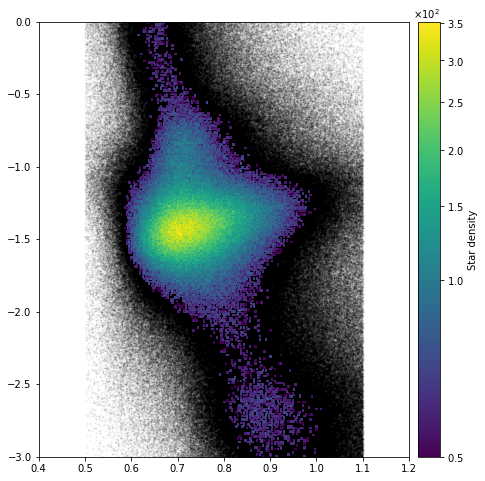

In [3]:
galcen_data, min_r, max_r = import_baseline_sample()

In [4]:
bin_collection = data_analysis.get_collapsed_bins(data = galcen_data,
                                                      theta = (0, 1),
                                                      BL_r_min = 5000,
                                                      BL_r_max = 12000,
                                                      BL_z_min = -200,
                                                      BL_z_max = 200,
                                                      N_bins = (10, 1),
                                                      r_drift = False,
                                                      debug = False)

In [5]:
# Old Approach

bins = bin_collection.bins
weighted_mean_velocities = []
weighted_var_velocities = []

for i, bin in enumerate(bins):
    weights = 1/bins[i].data.sig_vphi
    weighted_avg, weighted_var = bin.weighted_avg_and_std(bin.data.v_phi, weights)
    weighted_mean_velocities.append(weighted_avg)
    weighted_var_velocities.append(weighted_var)

In [122]:
# New Approach

bin_means = []
bin_mean_stds = []
boot_cis=[]

for i, bin in enumerate(bins):
    print("{}. bin".format(i))

    bootstrapped_means = []
    bindata = bin.data.v_phi.to_numpy()
    bindata_sig_vphi = bin.data.sig_vphi.to_numpy()
    data_length = len(bin.data.v_phi)
    idx_list = np.arange(data_length)
    bootstrapped_means = np.zeros(100)

    for i in range(100):

        rnd_idx = np.random.choice(idx_list, replace=True, size=len(bin.data.v_phi))
        test_sample = bindata[rnd_idx]
        weights = (1/bindata_sig_vphi)[rnd_idx]
        bootstrapped_means[i] = np.average(test_sample, weights=weights)
    
    bin_means.append(np.mean(bootstrapped_means))
    bin_mean_stds.append(np.std(bootstrapped_means))
    boot_cis.append(np.percentile(bootstrapped_means, [16, 84]))

bin_means = np.array(bin_means)
bin_mean_stds = np.array(bin_mean_stds)

0. bin
1. bin
2. bin
3. bin
4. bin
5. bin
6. bin
7. bin
8. bin
9. bin


In [7]:
print(bin_means)
print(bin_mean_stds)
for i, cis in enumerate(boot_cis):
    print("Bin {}: {}".format(i,(cis[1] - cis [0])/2))

[-219.22493258 -221.06761279 -223.94890064 -225.64030717 -224.82614079
 -221.74931279 -220.30862739 -219.92619759 -217.75993878 -218.17333729]
[1.59823799 0.35932968 0.15943675 0.15674255 0.21099255 0.15884534
 0.15658574 0.24930744 0.58489056 3.09510612]
Bin 0: 1.575151540986326
Bin 1: 0.37065096685458343
Bin 2: 0.1515922319436953
Bin 3: 0.1547572928085117
Bin 4: 0.20161267682314588
Bin 5: 0.15948411830846965
Bin 6: 0.1576276383204629
Bin 7: 0.24724639762183642
Bin 8: 0.5800834731719959
Bin 9: 2.998637340337197


In [28]:
for i, cis in enumerate(boot_cis):
    print("Bin {}: {}".format(i,(cis[1] - cis [0])/2))

Bin 0: 1.401304156236364
Bin 1: 0.3753074352788559
Bin 2: 0.16966570107524603
Bin 3: 0.15162738014974764
Bin 4: 0.19273864787774642
Bin 5: 0.17433046446170408
Bin 6: 0.17285612038679687
Bin 7: 0.3205284997285389
Bin 8: 0.4955910924387723
Bin 9: 2.9733564877522696


In [123]:
for i, cis in enumerate(boot_cis):
    print("Bin {}: {}".format(i,(cis[1] - cis [0])/2))

Bin 0: 1.4298479544309828
Bin 1: 0.3278061924736875
Bin 2: 0.16597561235386138
Bin 3: 0.15283243676999803
Bin 4: 0.1900018980412881
Bin 5: 0.15751907782077978
Bin 6: 0.12115660393688188
Bin 7: 0.2099600059996476
Bin 8: 0.7070802557772851
Bin 9: 2.925565164235479


In [21]:
for i, cis in enumerate(boot_cis):
    print("Bin {}: {}".format(i,np.sqrt(weighted_var_velocities[i])/len(bins[i].data.v_phi)))


Bin 0: 0.04077460987782072
Bin 1: 0.002534290424555547
Bin 2: 0.0006320030271168074
Bin 3: 0.00038440632105860316
Bin 4: 0.0004041641756971985
Bin 5: 0.000506464093173748
Bin 6: 0.0007483218830966231
Bin 7: 0.0020290496821495185
Bin 8: 0.013667880826447928
Bin 9: 0.25511504527576606


In [ ]:
# Old Function

bindata = bin.data.v_phi.to_numpy()
bindata_sig_vphi = bin.data.sig_vphi.to_numpy()
data_length = len(bin.data.v_phi)
idx_list = np.arange(data_length)
bootstrapped_means = np.zeros(100)

def bootstrap_weighted_error():

    for i in range(100):
        rnd_idx = np.random.choice(idx_list, replace=True, size=data_length)
        test_sample = bindata[rnd_idx]
        weights =(1/bindata_sig_vphi)[rnd_idx]
        bootstrapped_means[i] = np.average(test_sample, weights=weights)

    conf_int = np.percentile(bootstrapped_means, [16, 84])
    print(conf_int)
    return (conf_int[1] - conf_int [0])/2

In [ ]:
from numba import jit
import cProfile

# New Function

@jit(nopython=True)
def bootstrap_weighted_error(bin_vphi, bin_sig_vphi):
    
    data_length = len(bin_vphi)
    idx_list = np.arange(data_length)
    bootstrapped_means = np.zeros(100)

    for i in range(100):
        rnd_idx = np.random.choice(idx_list, replace=True, size=data_length)
        test_sample = bin_vphi[rnd_idx]
        sig_vphi = bin_sig_vphi[rnd_idx]
        bootstrapped_means[i] = (test_sample/sig_vphi).sum()/(1/sig_vphi).sum()
    conf_int = np.percentile(bootstrapped_means, [16, 84])

    return (conf_int[1] - conf_int [0])/2

In [ ]:
weighted_stds = []
for i, bin in enumerate(bin_collection.bins):

    bindata = bin.data.v_phi.to_numpy()
    bindata_sig_vphi = bin.data.sig_vphi.to_numpy()
    data_length = len(bin.data.v_phi)
    idx_list = np.arange(data_length)

    weighted_std = bootstrap_weighted_error(bindata, bindata_sig_vphi)
    weighted_stds.append(weighted_std)

for i, std in enumerate(weighted_stds):
    print("Bin {}: {}".format(i, std))